Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

# PyTorch Lightning Trainers

In this tutorial, we demonstrate TorchGeo trainers to train and test a model. We will use the [EuroSAT](https://torchgeo.readthedocs.io/en/stable/api/datasets.html#eurosat) dataset throughout this tutorial. Specifically, a subset containing only 100 images. We will train models to predict land cover classes.

It's recommended to run this notebook on Google Colab if you don't have your own GPU. Click the "Open in Colab" button above to get started.

## Setup

First, we install TorchGeo.

In [1]:
%pip install torchgeo

## Imports

Next, we import TorchGeo and any other libraries we need.

In [2]:
%matplotlib inline

import os
import csv
import tempfile

import matplotlib.pyplot as plt
import torch
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger

from torchgeo.datamodules import EuroSAT100DataModule
from torchgeo.models import ResNet18_Weights
from torchgeo.trainers import ClassificationTask

## Lightning modules

Our trainers use [PyTorch Lightning](https://pytorch-lightning.readthedocs.io/) to organize both the training code, and the dataloader setup code. This makes it easy to create and share reproducible experiments and results.

First we'll create a `EuroSAT100DataModule` object which is simply a wrapper around the [EuroSAT100](https://torchgeo.readthedocs.io/en/latest/api/datasets.html#eurosat) dataset. This object 1.) ensures that the data is downloaded, 2.) sets up PyTorch `DataLoader` objects for the train, validation, and test splits, and 3.) ensures that data from the same region **is not** shared between the training and validation sets so that you can properly evaluate the generalization performance of your model.

The following variables can be modified to control training.

In [3]:
batch_size = 10
num_workers = 2
max_epochs = 50
fast_dev_run = False

In [4]:
root = os.path.join(tempfile.gettempdir(), "eurosat100")
datamodule = EuroSAT100DataModule(
    root=root, batch_size=batch_size, num_workers=num_workers, download=True
)

Next, we create a `ClassificationTask` object that holds the model object, optimizer object, and training logic. We will use a ResNet-18 model that has been pre-trained on Sentinel-2 imagery.

In [5]:
task = ClassificationTask(
    loss="ce",
    model="resnet18",
    weights=ResNet18_Weights.SENTINEL2_ALL_MOCO,
    in_channels=13,
    num_classes=10,
    learning_rate=0.1,
    learning_rate_schedule_patience=5,
)

Downloading: "https://huggingface.co/torchgeo/resnet18_sentinel2_all_moco/resolve/main/resnet18_sentinel2_all_moco-59bfdff9.pth" to /root/.cache/torch/hub/checkpoints/resnet18_sentinel2_all_moco-59bfdff9.pth


  0%|          | 0.00/42.8M [00:00<?, ?B/s]

## Training

Now that we have the Lightning modules set up, we can use a PyTorch Lightning [Trainer](https://pytorch-lightning.readthedocs.io/en/latest/common/trainer.html) to run the training and evaluation loops. There are many useful pieces of configuration that can be set in the `Trainer` -- below we set up model checkpointing based on the validation loss, early stopping based on the validation loss, and a CSV based logger. We encourage you to see the [PyTorch Lightning docs](https://pytorch-lightning.readthedocs.io/) for other options that can be set here, e.g. Tensorboard logging, automatically selecting your optimizer's learning rate, and easy multi-GPU training.

In [6]:
accelerator = "gpu" if torch.cuda.is_available() else "cpu"
default_root_dir = os.path.join(tempfile.gettempdir(), "experiments")
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss", dirpath=default_root_dir, save_top_k=1, save_last=True
)
early_stopping_callback = EarlyStopping(monitor="val_loss", min_delta=0.00, patience=10)
logger = CSVLogger(save_dir=default_root_dir, name="tutorial_logs")

For tutorial purposes we deliberately lower the maximum number of training epochs.

In [7]:
trainer = Trainer(
    accelerator=accelerator,
    callbacks=[checkpoint_callback, early_stopping_callback],
    fast_dev_run=fast_dev_run,
    log_every_n_steps=1,
    logger=logger,
    min_epochs=1,
    max_epochs=max_epochs,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


When we first call `.fit(...)` the dataset will be downloaded and checksummed (if it hasn't already). This can take 5–10 minutes. After this, the training process will kick off, and results will be saved to a CSV file. 

In [8]:
trainer.fit(model=task, datamodule=datamodule)

  0%|          | 0/7717354 [00:00<?, ?it/s]

  0%|          | 0/1152 [00:00<?, ?it/s]

  0%|          | 0/383 [00:00<?, ?it/s]

  0%|          | 0/382 [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | model         | ResNet           | 11.2 M
1 | loss          | CrossEntropyLoss | 0     
2 | train_metrics | MetricCollection | 0     
3 | val_metrics   | MetricCollection | 0     
4 | test_metrics  | MetricCollection | 0     
---------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.852    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

We load the log files and plot the training RMSE over batches, and the validation RMSE over epochs. We can see that our model is just starting to converge, and would probably benefit from additional training time and a lower initial learning rate.

In [9]:
if not fast_dev_run:
    train_steps = []
    train_acc = []

    val_steps = []
    val_acc = []

    with open(
        os.path.join(default_root_dir, "tutorial_logs", "version_0", "metrics.csv")
    ) as f:
        csv_reader = csv.DictReader(f)
        for i, row in enumerate(csv_reader):
            try:
                train_acc.append(float(row["train_OverallAccuracy"]))
                train_steps.append(i)
            except ValueError:  # Ignore rows where train RMSE is empty
                pass

            try:
                val_acc.append(float(row["val_OverallAccuracy"]))
                val_steps.append(i)
            except ValueError:  # Ignore rows where val RMSE is empty
                pass

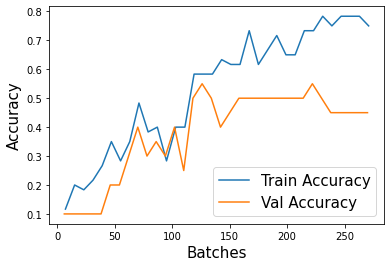

In [10]:
if not fast_dev_run:
    plt.figure()
    plt.plot(train_steps, train_acc, label="Train Accuracy")
    plt.plot(val_steps, val_acc, label="Val Accuracy")
    plt.legend(fontsize=15)
    plt.xlabel("Batches", fontsize=15)
    plt.ylabel("Accuracy", fontsize=15)
    plt.show()
    plt.close()

Finally, after the model has been trained, we can easily evaluate it on the test set.

In [11]:
trainer.test(model=task, datamodule=datamodule)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   test_AverageAccuracy    │            0.5            │
│       test_F1Score        │            0.5            │
│     test_JaccardIndex     │    0.40833336114883423    │
│   test_OverallAccuracy    │            0.5            │
│         test_loss         │    1.4150162935256958     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.4150162935256958,
  'test_AverageAccuracy': 0.5,
  'test_F1Score': 0.5,
  'test_JaccardIndex': 0.40833336114883423,
  'test_OverallAccuracy': 0.5}]